<h1 align="center">Large Language Models</h1>

## Integrantes

- Josué Say

## Enlaces

- [Enlace de Repositorio](https://github.com/JosueSay/HugginsFaceModels)
- [Ficha Técnica y Explicación de Modelos](https://github.com/JosueSay/HugginsFaceModels/tree/main/docs)

In [62]:
# %!pip install -r requirements.txt

## Librerias


In [63]:
import os, time, psutil
from dotenv import load_dotenv
from huggingface_hub import login, whoami
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from rich.live import Live
from rich.table import Table
import pandas as pd
from transformers import TextIteratorStreamer
from threading import Thread
import matplotlib.pyplot as plt

## Constantes

In [64]:
load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN", "")

# IDs models
MODEL_ID_TINY_LLAMA="TinyLlama/TinyLlama-1.1B-Chat-v1.0"
MODEL_ID_QWEN="Qwen/Qwen2.5-0.5B-Instruct"
MODEL_ID_DOCTOR_SHOTGUN="Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct"
MODEL_ID_META_LLAMA="meta-llama/Llama-2-7b-hf"

## Login y device

In [65]:
def loginHF(hfToken: str):
    if hfToken == "":
        print("No se encontró HF_TOKEN en el .env. Usando valor vacío...")
    login(hfToken)
    print("Login de HuggingFace completado.")

In [66]:
def getDevice() -> str:
    if torch.cuda.is_available():
        return "cuda"
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return "mps"
    return "cpu"

## Métricas de sistema

In [67]:
def getSystemUsage():
    vm = psutil.virtual_memory()
    return {
        "cpu_pct": psutil.cpu_percent(interval=None),
        "ram_pct": round(vm.percent, 2),
        "ram_used_mb": round((vm.total - vm.available) / (1024**2), 1),
    }

In [68]:
def getGpuUsage():
    if torch.cuda.is_available():
        idx = torch.cuda.current_device()
        torch.cuda.synchronize()
        alloc = torch.cuda.memory_allocated(idx) / (1024**2)
        reserved = torch.cuda.memory_reserved(idx) / (1024**2)
        return {
            "gpu": torch.cuda.get_device_name(idx),
            "vram_alloc_mb": round(alloc, 1),
            "vram_reserved_mb": round(reserved, 1),
        }
    return {"gpu": "none", "vram_alloc_mb": 0.0, "vram_reserved_mb": 0.0}

## Formateadores de prompts

In [69]:
def fmtTinyLlama(msg, system="You are a helpful assistant."):
    # Se usa chat template si el modelo lo tiene
    return [
        {"role": "system", "content": system},
        {"role": "user", "content": msg},
    ]

In [70]:
def fmtQwen(msg, system="You are Qwen, a helpful assistant."):
    return [
        {"role": "system", "content": system},
        {"role": "user", "content": msg},
    ]

In [71]:
def fmtDoctorShotgun(msg, system="Follow the instruction."):
    # Formato Alpaca modificado de la card
    return f"""### Instruction:
                {system}

                ### Input:
                {msg}

                ### Response:
            """

In [72]:
def fmtLlama2(msg):  # pretrained (no chat)
    return msg

## Presets por modelo

In [73]:
MODEL_PRESETS = {
    MODEL_ID_TINY_LLAMA: {
        "gen_kwargs": dict(
            max_new_tokens=256, temperature=0.7, top_p=0.95, top_k=50,
            repetition_penalty=1.1, do_sample=True
        ),
        "prompt_fmt": fmtTinyLlama,
        "use_chat_template": True
    },
    MODEL_ID_QWEN: {
        "gen_kwargs": dict(
            max_new_tokens=512, temperature=0.7, top_p=0.9, top_k=40,
            repetition_penalty=1.05, do_sample=True
        ),
        "prompt_fmt": fmtQwen,
        "use_chat_template": True
    },
    MODEL_ID_DOCTOR_SHOTGUN: {
        "gen_kwargs": dict(
            max_new_tokens=300, temperature=0.7, top_p=0.9, top_k=40,
            repetition_penalty=1.05, do_sample=True
        ),
        "prompt_fmt": fmtDoctorShotgun,
        "use_chat_template": False
    },
    MODEL_ID_META_LLAMA: {
        "gen_kwargs": dict(
            max_new_tokens=200, temperature=0.7, top_p=0.9, top_k=40,
            repetition_penalty=1.1, do_sample=True
        ),
        "prompt_fmt": fmtLlama2,
        "use_chat_template": False
    },
}

## Cargar modelo y tokenizer

In [74]:
def loadModel(modelId, use4bit=False, dtype=None):
    device = getDevice()
    if dtype is None:
        dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16

    tokenizer = AutoTokenizer.from_pretrained(modelId, use_fast=True)

    if use4bit:
        model = AutoModelForCausalLM.from_pretrained(modelId, device_map="auto", load_in_4bit=True)
    else:
        model = AutoModelForCausalLM.from_pretrained(modelId, torch_dtype=dtype, device_map="auto")

    gen = pipeline("text-generation", model=model, tokenizer=tokenizer, return_full_text=False)
    print(f"Modelo '{modelId}' cargado en {device}.")
    return gen, tokenizer

## Construcción de prompt

In [75]:
def buildPrompt(modelId, userText, systemText=None, tokenizer=None):
    preset = MODEL_PRESETS[modelId]
    fmt = preset["prompt_fmt"]
    payload = fmt(userText, systemText) if systemText is not None else fmt(userText)
    if preset.get("use_chat_template", False):
        return tokenizer.apply_chat_template(payload, tokenize=False, add_generation_prompt=True)
    return payload

## Inferencia

In [76]:
def runInferenceBatch(modelId, userText, systemText=None, overrideGenKwargs=None, use4bit=False):
    gen, tok = loadModel(modelId, use4bit=use4bit)
    prompt = buildPrompt(modelId, userText, systemText, tokenizer=tok)

    genKwargs = MODEL_PRESETS[modelId]["gen_kwargs"].copy()
    if overrideGenKwargs:
        genKwargs.update(overrideGenKwargs)

    sys_before = getSystemUsage()
    gpu_before = getGpuUsage()
    t0 = time.time()
    out = gen(prompt, **genKwargs)
    t1 = time.time()
    sys_after = getSystemUsage()
    gpu_after = getGpuUsage()

    text = out[0]["generated_text"]
    input_tokens  = len(tok(prompt).input_ids)
    output_tokens = len(tok(text).input_ids)
    elapsed = round(t1 - t0, 3)

    metrics = {
        "modelo": modelId,
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
        "tiempo_seg": elapsed,
        "tok_s": round(output_tokens / max(elapsed, 1e-6), 2),
        "temperature": genKwargs.get("temperature"),
        "max_new_tokens": genKwargs.get("max_new_tokens"),
        "top_p": genKwargs.get("top_p"),
        "top_k": genKwargs.get("top_k"),
        "repetition_penalty": genKwargs.get("repetition_penalty"),
        "cpu_before": sys_before["cpu_pct"], "cpu_after": sys_after["cpu_pct"],
        "ram_before_pct": sys_before["ram_pct"], "ram_after_pct": sys_after["ram_pct"],
        "vram_before_mb": gpu_before["vram_alloc_mb"], "vram_after_mb": gpu_after["vram_alloc_mb"]
    }
    return text, metrics

## Inferencia con streaming

In [77]:
def makeLiveTable():
    table = Table(title="Inferencia (en vivo)", expand=True)
    table.add_column("Modelo")
    table.add_column("Tokens out")
    table.add_column("t (s)")
    table.add_column("tok/s")
    table.add_column("CPU %")
    table.add_column("RAM %")
    table.add_column("VRAM MB")
    return table

In [78]:
def runInferenceStreaming(modelId, userText, systemText=None, overrideGenKwargs=None, use4bit=False, csvPath=None):
    gen, tok = loadModel(modelId, use4bit=use4bit)
    prompt = buildPrompt(modelId, userText, systemText, tokenizer=tok)

    genKwargs = MODEL_PRESETS[modelId]["gen_kwargs"].copy()
    if overrideGenKwargs:
        genKwargs.update(overrideGenKwargs)

    inputs = tok(prompt, return_tensors="pt").to(gen.model.device)

    sys_before = getSystemUsage()
    gpu_before = getGpuUsage()
    t0 = time.time()

    streamer = TextIteratorStreamer(tok, skip_special_tokens=True, skip_prompt=True)

    def _worker():
        gen.model.generate(
            **inputs,
            streamer=streamer,
            do_sample=genKwargs.get("do_sample", True),
            max_new_tokens=genKwargs.get("max_new_tokens", 200),
            temperature=genKwargs.get("temperature", 0.7),
            top_p=genKwargs.get("top_p", 0.9),
            top_k=genKwargs.get("top_k", 40),
            repetition_penalty=genKwargs.get("repetition_penalty", 1.0),
        )

    thread = Thread(target=_worker)
    thread.start()

    tokens_collected = []
    table = makeLiveTable()
    with Live(table, refresh_per_second=4):
        partial = ""
        while True:
            try:
                token = next(streamer)
                partial += token
                tokens_collected.append(token)
            except StopIteration:
                break

            elapsed = max(time.time() - t0, 1e-6)
            out_tok = len(tok(partial).input_ids)
            sys_now = getSystemUsage()
            gpu_now = getGpuUsage()

            table.rows = []
            table.add_row(
                modelId,
                str(out_tok),
                f"{elapsed:.2f}",
                f"{out_tok/elapsed:.2f}",
                f"{sys_now['cpu_pct']:.0f}",
                f"{sys_now['ram_pct']:.1f}",
                f"{gpu_now['vram_alloc_mb']:.0f}"
            )

    thread.join()
    t1 = time.time()

    text = partial
    input_tokens  = len(inputs.input_ids[0])
    output_tokens = len(tok(text).input_ids)
    elapsed = round(t1 - t0, 3)
    sys_after = getSystemUsage()
    gpu_after = getGpuUsage()

    metrics = {
        "modelo": modelId,
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
        "tiempo_seg": elapsed,
        "tok_s": round(output_tokens / max(elapsed, 1e-6), 2),
        "temperature": genKwargs.get("temperature"),
        "max_new_tokens": genKwargs.get("max_new_tokens"),
        "top_p": genKwargs.get("top_p"),
        "top_k": genKwargs.get("top_k"),
        "repetition_penalty": genKwargs.get("repetition_penalty"),
        "cpu_before": sys_before["cpu_pct"], "cpu_after": sys_after["cpu_pct"],
        "ram_before_pct": sys_before["ram_pct"], "ram_after_pct": sys_after["ram_pct"],
        "vram_before_mb": gpu_before["vram_alloc_mb"], "vram_after_mb": gpu_after["vram_alloc_mb"]
    }

    if csvPath:
        df = pd.DataFrame([metrics])
        df.to_csv(csvPath, mode="a", index=False, header=not os.path.exists(csvPath))

    return text, metrics

## Esportación csv

In [79]:
def benchmarkModels(models, prompt, systemText=None, runs=1, use4bit=True, csvPath="metrics.csv", override=None):
    rows = []
    for modelId in models:
        for i in range(runs):
            print(f"\n=== {modelId} | run {i+1}/{runs} ===")
            text, m = runInferenceStreaming(
                modelId, prompt, systemText=systemText,
                overrideGenKwargs=override, use4bit=use4bit, csvPath=csvPath
            )
            m["run"] = i+1
            rows.append(m)
    return pd.DataFrame(rows)

## Lectura de csv

In [80]:
def loadResults(csvPath="metrics.csv"):
    return pd.read_csv(csvPath) if os.path.exists(csvPath) else pd.DataFrame()

In [81]:
def plotQuick(df):
    if df.empty:
        print("No hay datos para graficar.")
        return
    # tiempo
    plt.figure()
    df.groupby("modelo")["tiempo_seg"].mean().plot(kind="bar")
    plt.title("Tiempo promedio por modelo (s)")
    plt.ylabel("segundos")
    plt.show()
    # tok/s
    plt.figure()
    df.groupby("modelo")["tok_s"].mean().plot(kind="bar")
    plt.title("Velocidad promedio (tok/s)")
    plt.ylabel("tokens/segundo")
    plt.show()

## Pipeline

In [82]:
loginHF(hfToken=HF_TOKEN)
prompt = "Explain what a transformer model is in simple terms."

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Login de HuggingFace completado.


In [83]:
models = [
    MODEL_ID_TINY_LLAMA,
    MODEL_ID_QWEN,
    MODEL_ID_DOCTOR_SHOTGUN
]
CSV_PATH = "metrics_lab_models.csv"

### Tiny llama

In [84]:
text_tiny, metrics_tiny = runInferenceStreaming(
    MODEL_ID_TINY_LLAMA,
    userText=prompt,
    systemText="You are a helpful assistant.",
    use4bit=True,
    csvPath=CSV_PATH
)
print("\nTinyLlama métricas:", metrics_tiny)
print(text_tiny[:500])

tokenizer_config.json: 0.00B [00:00, ?B/s]

d:\repositorios\UVG\2025\HugginsFaceModels\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\josue\.cache\huggingface\hub\models--TinyLlama--TinyLlama-1.1B-Chat-v1.0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fall

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cpu


Output()

Modelo 'TinyLlama/TinyLlama-1.1B-Chat-v1.0' cargado en cpu.



TinyLlama métricas: {'modelo': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0', 'input_tokens': 44, 'output_tokens': 180, 'tiempo_seg': 194.688, 'tok_s': 0.92, 'temperature': 0.7, 'max_new_tokens': 256, 'top_p': 0.95, 'top_k': 50, 'repetition_penalty': 1.1, 'cpu_before': 17.4, 'cpu_after': 0.0, 'ram_before_pct': 54.0, 'ram_after_pct': 54.3, 'vram_before_mb': 0.0, 'vram_after_mb': 0.0}
A transformer model is an artificial neural network (ANN) that has been modified to perform sequence-to-sequence translation tasks, such as natural language processing (NLP) and machine translation. It works by processing inputs in sequence format and generating outputs based on the logic of the input sequence. The transformers' architecture is divided into two parts: the encoder and the decoder. The encoder encodes each input sequence into a sequence of hidden states, while the decoder uses the


### Qwen

In [85]:
text_qwen, metrics_qwen = runInferenceStreaming(
    MODEL_ID_QWEN,
    userText=prompt,
    systemText="You are Qwen, created by Alibaba Cloud. You are a helpful assistant.",
    use4bit=True,
    csvPath=CSV_PATH
)
print("\nQwen métricas:", metrics_qwen)
print(text_qwen[:500])

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Device set to use cpu


Output()

Modelo 'Qwen/Qwen2.5-0.5B-Instruct' cargado en cpu.



Qwen métricas: {'modelo': 'Qwen/Qwen2.5-0.5B-Instruct', 'input_tokens': 40, 'output_tokens': 212, 'tiempo_seg': 89.175, 'tok_s': 2.38, 'temperature': 0.7, 'max_new_tokens': 512, 'top_p': 0.9, 'top_k': 40, 'repetition_penalty': 1.05, 'cpu_before': 67.0, 'cpu_after': 0.0, 'ram_before_pct': 52.4, 'ram_after_pct': 52.5, 'vram_before_mb': 0.0, 'vram_after_mb': 0.0}
A transformer model is a type of neural network architecture that was designed to improve the performance of language models like self-attention and language models. It is based on the idea of parallelization, which allows the transformer model to take advantage of the parallel processing power of a single computer to improve the overall performance of the model.
In simple terms, a transformer model is like a "streaming" model that takes input from a sequence of characters or words and produces 


### Doctor-Shotgun

In [86]:
text_doc, metrics_doc = runInferenceStreaming(
    MODEL_ID_DOCTOR_SHOTGUN,
    userText=prompt,
    systemText="Follow the instruction carefully.",
    use4bit=True,
    csvPath=CSV_PATH
)
print("\nDoctor-Shotgun métricas:", metrics_doc)
print(text_doc[:500])

tokenizer_config.json: 0.00B [00:00, ?B/s]

d:\repositorios\UVG\2025\HugginsFaceModels\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\josue\.cache\huggingface\hub\models--Doctor-Shotgun--TinyLlama-1.1B-32k-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not install

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

Device set to use cpu


Output()

Modelo 'Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct' cargado en cpu.



Doctor-Shotgun métricas: {'modelo': 'Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct', 'input_tokens': 40, 'output_tokens': 302, 'tiempo_seg': 320.583, 'tok_s': 0.94, 'temperature': 0.7, 'max_new_tokens': 300, 'top_p': 0.9, 'top_k': 40, 'repetition_penalty': 1.05, 'cpu_before': 35.5, 'cpu_after': 0.0, 'ram_before_pct': 55.9, 'ram_after_pct': 54.7, 'vram_before_mb': 0.0, 'vram_after_mb': 0.0}

A Transformer is an encoder-decoder architecture that is used to process and generate text data. It has the following characteristics:

1. Encoder: The encoder takes a sequence of input tokens (text) and generates a sequence of intermediate representations (hidden states). This process is often referred to as the encoder-decoder model.

2. Decoder: The decoder takes the intermediate representations generated by the encoder and generates new tokens, one at a time. This process is often referred 


## Benchmark secuencial

In [87]:
df_results = benchmarkModels(
    models=models,
    prompt=prompt,
    systemText="You are a helpful assistant.",
    runs=1,
    use4bit=True,
    csvPath=CSV_PATH
)
display(df_results)


=== TinyLlama/TinyLlama-1.1B-Chat-v1.0 | run 1/1 ===


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Device set to use cpu


Output()

Modelo 'TinyLlama/TinyLlama-1.1B-Chat-v1.0' cargado en cpu.



=== Qwen/Qwen2.5-0.5B-Instruct | run 1/1 ===


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Device set to use cpu


Output()

Modelo 'Qwen/Qwen2.5-0.5B-Instruct' cargado en cpu.



=== Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct | run 1/1 ===


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Device set to use cpu


Output()

Modelo 'Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct' cargado en cpu.


,modelo,input_tokens,output_tokens,tiempo_seg,tok_s,temperature,max_new_tokens,top_p,top_k,repetition_penalty,cpu_before,cpu_after,ram_before_pct,ram_after_pct,vram_before_mb,vram_after_mb,run
0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,44,185,255.643,0.72,0.7,256,0.95,50,1.10,79.6,0.0,55.1,55.2,0.0,0.0,1
1,Qwen/Qwen2.5-0.5B-Instruct,30,87,39.539,2.20,0.7,512,0.90,40,1.05,43.0,0.0,55.2,55.2,0.0,0.0,1
2,Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct,41,272,328.751,0.83,0.7,300,0.90,40,1.05,80.5,0.0,55.4,55.0,0.0,0.0,1


## Visualizar data

In [88]:
df_metrics = loadResults(CSV_PATH)
display(df_metrics)

,modelo,input_tokens,output_tokens,tiempo_seg,tok_s,temperature,max_new_tokens,top_p,top_k,repetition_penalty,cpu_before,cpu_after,ram_before_pct,ram_after_pct,vram_before_mb,vram_after_mb
0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,44,180,194.688,0.92,0.7,256,0.95,50,1.10,17.4,0.0,54.0,54.3,0.0,0.0
1,Qwen/Qwen2.5-0.5B-Instruct,40,212,89.175,2.38,0.7,512,0.90,40,1.05,67.0,0.0,52.4,52.5,0.0,0.0
2,Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct,40,302,320.583,0.94,0.7,300,0.90,40,1.05,35.5,0.0,55.9,54.7,0.0,0.0
3,TinyLlama/TinyLlama-1.1B-Chat-v1.0,44,185,255.643,0.72,0.7,256,0.95,50,1.10,79.6,0.0,55.1,55.2,0.0,0.0
4,Qwen/Qwen2.5-0.5B-Instruct,30,87,39.539,2.20,0.7,512,0.90,40,1.05,43.0,0.0,55.2,55.2,0.0,0.0
5,Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct,41,272,328.751,0.83,0.7,300,0.90,40,1.05,80.5,0.0,55.4,55.0,0.0,0.0


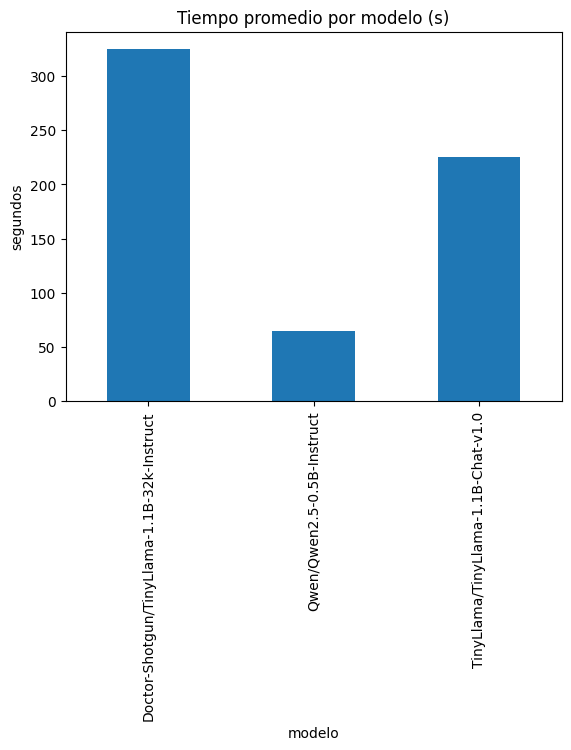

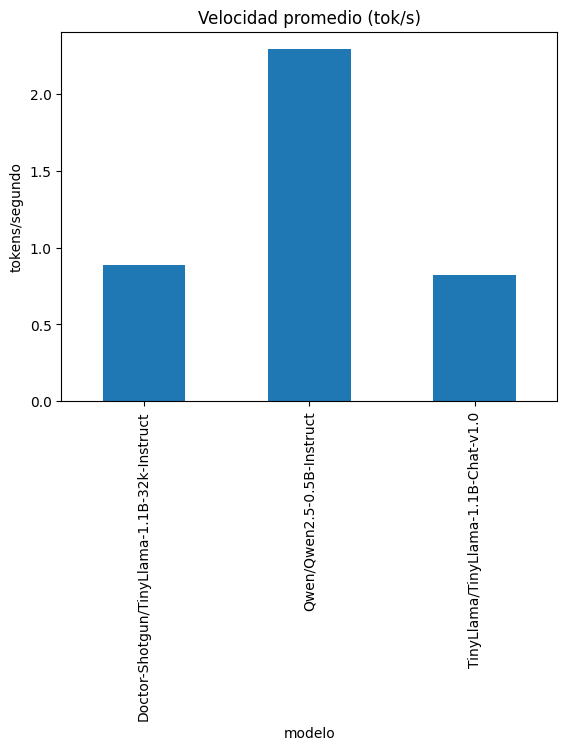

In [89]:
plotQuick(df_metrics)

In [90]:
df_metrics.to_csv("resultados_finales_lab.csv", index=False)
print("Resultados exportados a resultados_finales_lab.csv")

Resultados exportados a resultados_finales_lab.csv


## Análisis comparativo de rendimiento de modelos de lenguaje

Los resultados muestran diferencias entre los tres modelos evaluados en **tiempo de inferencia**, **velocidad de generación** y **uso de recursos**, contrastados con la ejecución de **ChatGPT**.

### 1. Resultados generales de inferencia

| Modelo                                         | Tokens generados | Tiempo total (s)        | Velocidad (tokens/s) | Observaciones                                                                        |
| ---------------------------------------------- | ---------------- | ----------------------- | -------------------- | ------------------------------------------------------------------------------------ |
| **TinyLlama/TinyLlama-1.1B-Chat-v1.0**         | 180–185          | 195–256 ($\approx$ 3–4.1 min)   | 0.72–0.92            | Generación estable pero lenta; el tamaño del modelo (1.1B) eleva el tiempo de carga. |
| **Qwen/Qwen2.5-0.5B-Instruct**                 | 87–212           | 39–89 ($\approx$ 1.3 min)       | 2.2–2.4              | El más rápido; tamaño reducido (0.5B) y arquitectura optimizada.                     |
| **Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct** | 272–302          | 320–329 ($\approx$ 5.3–5.5 min) | 0.83–0.94            | El más lento; contexto extendido (32k) aumenta el costo computacional.               |

Durante las pruebas, el uso de CPU osciló entre **17 % y 80 %**, y la **RAM** se mantuvo entre **52 % y 55 %**. No hubo uso de GPU (latencia alta).

### 2. Interpretación del rendimiento

- **TinyLlama:** inferencia lenta ($\approx$ 4 min). Lento para implementación en tiempo real.
- **Qwen:** más eficiente, completó la generación en menos de 90 s con buena coherencia.
- **Doctor-Shotgun:** el más costoso en tiempo (>5 min), coherente con su entrenamiento en contextos largos.

### 3. Comparación con ChatGPT

ChatGPT generó la misma respuesta casi **instantáneamente**, sin retardo perceptible.
Esto evidencia la diferencia entre:

- **Ejecución local:** dependiente del hardware y tamaño del modelo.
- **Ejecución en la nube (ChatGPT):** sobre infraestructura optimizada con GPUs y paralelización.

### 4. Resultados visuales

Las gráficas muestran el **tiempo promedio de respuesta** y la **velocidad de generación (tok/s)**, donde se confirma que Qwen supera en eficiencia a los otros modelos.

![Tiempo promedio](./images/tiempo_promedio.png)

![Velocidad promedio](./images/velocidad_promedio.png)

- **Doctor-Shotgun:** mayor tiempo, menor eficiencia.
- **TinyLlama:** rendimiento intermedio.
- **Qwen:** mejor equilibrio entre calidad, tiempo y velocidad.

### 5. Conclusiones

1. **Velocidad:** Qwen fue el más rápido; ChatGPT el más eficiente por su infraestructura.
2. **Recursos:** uso estable de RAM ($\approx$ 55 %) y CPU variable; la falta de GPU elevó los tiempos.
3. **Calidad:**
   - TinyLlama: salida genérica.
   - Qwen: precisa y estructurada.
   - Doctor-Shotgun: extensa pero menos coherente.
   - ChatGPT: clara y completa.
4. **Factores de lentitud:** carga inicial, tamaño (1.1B) y ejecución en CPU.
